# Data exploration in advance of model selection

Thanks to neptune.ai for their great tutorials in visualization; they were quite helpful here. Much of the visualization in this section was [described helpfully here](https://neptune.ai/blog/select-model-for-time-series-prediction-task).

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Import data

The CSV here is an extract of the most recent Google BigQuery run of 'weekly_variables_flattened.sql'. My intent was to do this analysis in Google Colab, but as it turns out, activating that feature in my personal cloud instance would cost me about $400 on the low end, so instead I'll be doing it here.

In [2]:
# import data extracted from last GCP run of 'weekly_variables_flattened'
df = pd.read_csv("weekly_variables_flattened.csv")
df['week_start'] = pd.to_datetime(df['week_start'])
df = df.sort_values(by='week_start', ascending=True)
df.set_index('week_start', inplace=True)

In [3]:

print(df.head())
print(len(df))
# df = df.dropna()
print(len(df))

            approving  disapproving  unsure_or_no_data  BusinessApplications  \
week_start                                                                     
2004-07-04       48.0     48.333333           3.666667                159034   
2004-07-11       48.0     48.333333           3.666667                159034   
2004-07-18       48.0     48.333333           3.666667                159034   
2004-07-25       48.0     48.333333           3.666667                159034   
2004-08-01       50.0     46.500000           3.500000                191673   

            ConstructionSpending  DurableGoodsNewOrders  \
week_start                                                
2004-07-04             1006184.0               186835.0   
2004-07-11             1006184.0               186835.0   
2004-07-18             1006184.0               186835.0   
2004-07-25             1006184.0               186835.0   
2004-08-01             1013616.0               183728.0   

            International

### Review NA values

We know that there are instances where census data lags, or some components of the economic indicators were not included in certain time periods. These will need to be examined prior to analysis:

In [4]:
null_rows = df[df.isnull().any(axis=1)]

print(null_rows)
print(f'{len(null_rows)} rows with null values found: {len(null_rows)} out of {len(df)} total')

            approving  disapproving  unsure_or_no_data  BusinessApplications  \
week_start                                                                     
2021-12-05        NaN           NaN                NaN                428051   
2021-12-12        NaN           NaN                NaN                428051   
2021-12-19        NaN           NaN                NaN                428051   
2021-12-26        NaN           NaN                NaN                428051   
2022-12-04        NaN           NaN                NaN                423977   
2022-12-11        NaN           NaN                NaN                423977   
2022-12-18        NaN           NaN                NaN                423977   
2022-12-25        NaN           NaN                NaN                423977   
2024-12-01       39.0          56.0                5.0                457544   
2024-12-08       39.0          56.0                5.0                457544   
2024-12-15       39.0          56.0     

Given the relatively small number of NAs in the data - just over 1% of the total - we will proceed with exploration, and interpolate these prior to model building.

## Data visualizations: The Dependent (Outcome) Variable

It is unfortunate that we do not have sufficient data at the current time to build a model through the current administration; at the time of this writing, the full tenure of the Biden presidency is not reflected in this data.

That said, in addition to the quality checks done in previous instances, the visualization in the first figure below can be [compared to prior work](https://ballotpedia.org/Joe_Biden%27s_executive_orders_and_actions) to see that the structure of the data is as would be expected.

### Seasonality

First, a simple trend of the outcome variable 'orders_outcome_var': we find some clear outliers that may need to be addressed prior to model implementation.

In [5]:
fig1 = px.line(df, x=df.index, y='orders_outcome_var')
fig1.update_layout(
    xaxis_title = 'Date',
    yaxis_title = 'No. Exec. Orders',
    title = 'Executive Orders by Date'
)
fig1.show()

We see below that there is a clear seasonal component to the data: this will require differencing (and suggests a SARIMA regression model be used).

In [6]:
fig2 = seasonal_decompose(x=df['orders_outcome_var'], model='additive')

fig2 = fig2.plot()

fig2.tight_layout(pad = 3)

fig2 = plotly.tools.mpl_to_plotly(fig2)
fig2.update_layout(
    title = 'Seasonal Decomposition showing strong seasonality',
    title_x = .1,
    title_y = .97
)
fig2.show();


### Autocorrelation

Prior to looking for autocorrelation, we will difference the data based on the seasonal period of one year.
Plotting *partial autocorrection correlation* indicates that there is a strong autocorrelation between high values in one period and a high value in the following time period.

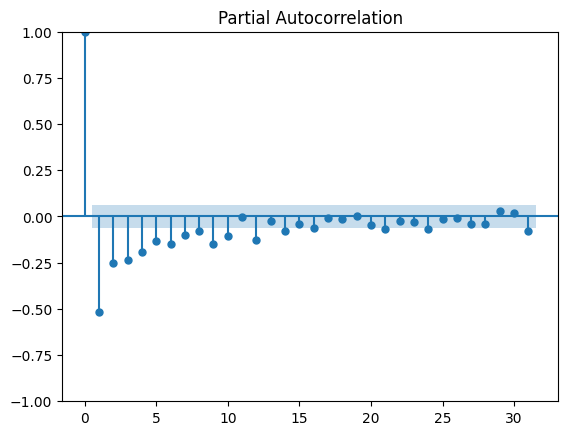

In [7]:
df['orders_outcome_var_diff']=df['orders_outcome_var']-df['orders_outcome_var'].shift()
plot_pacf(df['orders_outcome_var_diff'].dropna());

### Stationarity

Given the wobbly trend line in the figure above, we will use the Dickey-Fuller test to examine stationarity. This is performed on the differenced data.

The results below indicate that the differenced data is now stationary (p < 0.05, by no small amount.)

In [8]:
adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(df['orders_outcome_var_diff'].dropna().values)

print('ADF test statistic:', adf)
print('ADF p-value:', pval)
print('Number of lags used:', usedlag)
print('Number of observations:', nobs)
print('Critical values:', crit_vals)
print('Best information criterion:', icbest)

ADF test statistic: -13.51328357251598
ADF p-value: 2.826005937992845e-25
Number of lags used: 15
Number of observations: 1053
Critical values: {'1%': np.float64(-3.4365753682419133), '5%': np.float64(-2.8642886771163396), '10%': np.float64(-2.568233502009814)}
Best information criterion: 5778.721360947314


Given these results, we will use a **Seasonal Auto-Regressive Integrated Moving Average with Exogenous Variable** (SARIMAX) model to attempt to predict future counts of executive orders by week.

## Data Visualizations: The Independent 'Exogenous' Variables

In a SARIMAX model, the exogenous variables are [treated as ordinary least squares regressors](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_faq.html) and need to be examined for multicollinearity.

Below, [significant multicollnearity (> 0.8)](https://online.stat.psu.edu/stat462/node/177) can be seen in many of the exogenous variables; referencing [work with similarly multicollinear characteristics](https://in2p3.hal.science/INSA-CVL/hal-03424542v1), we will - rather than attempting to use stepwise or exhaustive feature analysis - perform principal component analysis (PCA) on the exogenous variable set and use those principal components as 'exog' input in the SARIMAX model.


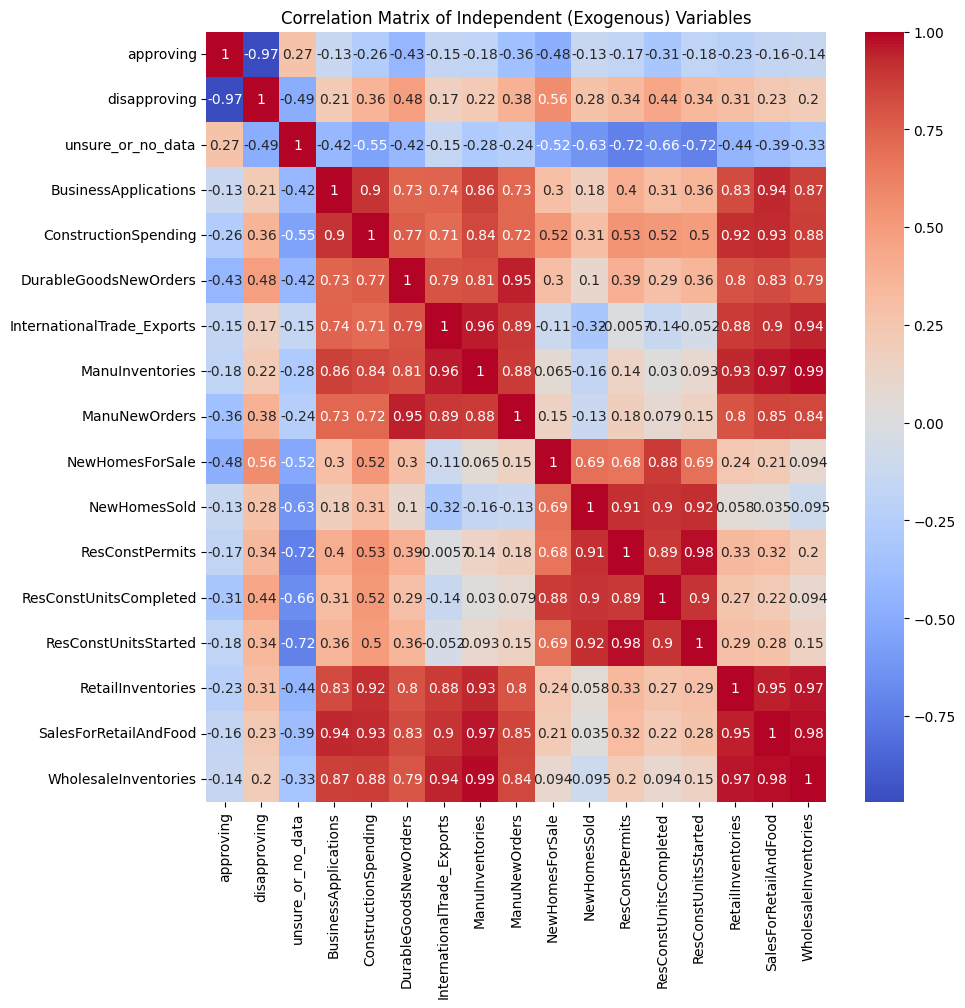

In [9]:
df_exog_vars = df.drop(['orders_outcome_var', 'orders_outcome_var_diff'], axis = 1)
correlation_matrix = df_exog_vars.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax).set(title = 'Correlation Matrix of Independent (Exogenous) Variables')

plt.show()

## Missing Values in Exogenous Variables

There are some time periods where the census data is missing certain economic indicator values, and we will use spline interpolation to fill those values (as neither PCA nor SARIMAX allows for missing values). Line graphs before and after are reviewed to confirm that interpolation does not result in visible trend change.

In [10]:
fig4 = px.line(df_exog_vars)
fig4.update_layout(
    xaxis_title = 'Date',
    yaxis_title = 'No. Exec. Orders',
    title = 'Exogenous Variables as Line Graph'
)
fig4.show()
null_rows = df_exog_vars[df_exog_vars.isnull().any(axis=1)]
print(f'{len(null_rows)} rows with null values found: {len(null_rows)} out of {len(df_exog_vars)} total')


13 rows with null values found: 13 out of 1070 total


In [11]:
df_exog_interpolated = df_exog_vars.interpolate(method='spline', order = 3) # order 3 is cubic
fig5 = px.line(df_exog_interpolated)
fig5.update_layout(
    xaxis_title = 'Date',
    yaxis_title = 'No. Exec. Orders',
    title = 'Exogenous Variables (Interpolated) as Line Graph'
)
fig4.show()
null_rows = df_exog_interpolated[df_exog_interpolated.isnull().any(axis=1)]
print(f'{len(null_rows)} rows with null values found: {len(null_rows)} out of {len(df_exog_interpolated)} total')

c:\Users\rtbra\OneDrive\Documents\WGU\D610\executive_order_prediction\.venv\Lib\site-packages\pandas\core\missing.py:604: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



0 rows with null values found: 0 out of 1070 total


## Principal Component Analysis

### Standardization of exogenous variables

In [12]:
scaler = StandardScaler()
df_to_standardize = df_exog_interpolated.drop(['disapproving'], axis=1)
df_standardized = scaler.fit_transform(df_to_standardize)

# create matrix of all principal components

pca = PCA()
pca.fit(df_standardized)

print(pca.components_)

[[-1.13977988e-01 -1.96907127e-01  3.04171609e-01  3.26251029e-01
   3.00935542e-01  2.64852728e-01  2.99036565e-01  2.84493117e-01
   1.53551675e-01  9.17831260e-02  1.86262429e-01  1.60883541e-01
   1.74190836e-01  3.15797918e-01  3.20240115e-01  3.04965838e-01]
 [-7.99896334e-02 -2.50282028e-01 -5.83337368e-02  1.78150719e-02
  -6.56578238e-02 -2.73938111e-01 -2.07773556e-01 -1.70135064e-01
   3.28171312e-01  4.28004529e-01  3.60704822e-01  3.94084303e-01
   3.73578393e-01 -1.04931343e-01 -1.26427411e-01 -1.81442961e-01]
 [ 8.29643632e-01 -6.78048692e-02  1.77038740e-01  6.17763669e-02
  -2.06796835e-01  1.48935325e-02  4.99723710e-02 -2.03512558e-01
  -2.93662916e-01  1.46758728e-01  1.62804146e-01 -3.24177399e-02
   1.42841242e-01  6.18042117e-02  1.18456997e-01  1.06985926e-01]
 [ 1.07243094e-01  5.65760538e-01  2.35838105e-01  2.97986707e-01
  -2.66335131e-01 -1.29134658e-01  2.86563645e-02 -1.76685437e-01
   5.31072664e-01 -3.38562435e-02 -1.75201218e-01  2.03418417e-01
  -1.81

### Using a scree plot and cumulative variance ratio of explained variance ratio to select principal components for use in SARIMAX as exogenous variables:

The scree plot elbow at 4 principal components, and the cumulative explained variance of the first four principal components at ~94%, reveal that four principal components of the exogenous variables are sufficient for use in the SARIMAX model.

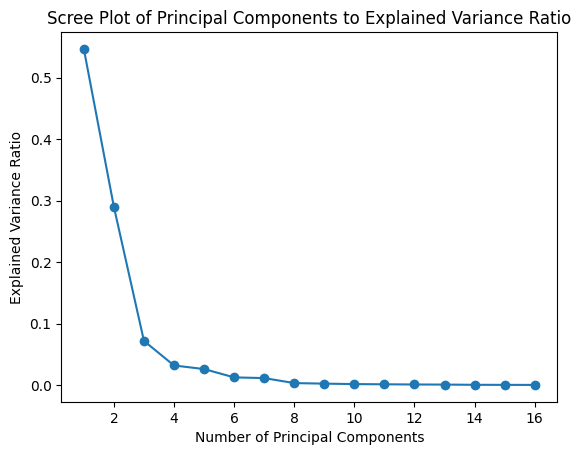

[0.54660966 0.83642271 0.90816453 0.93994265 0.96590585 0.97831245
 0.98958994 0.99274269 0.99497806 0.9964964  0.99766848 0.99853465
 0.99923728 0.99957836 0.99984189 1.        ]


In [13]:
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot using explained variance ratio
plt.plot(range(1,
               len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_,
         'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of Principal Components to Explained Variance Ratio')
plt.show()

print(pca.explained_variance_ratio_.cumsum())